Epoch 1/50


C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0865
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0080
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0053
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0047
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0050
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0039
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0052
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0043
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0034
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0044
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0034
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0034
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0033
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0028
Epoch 16/50
36/

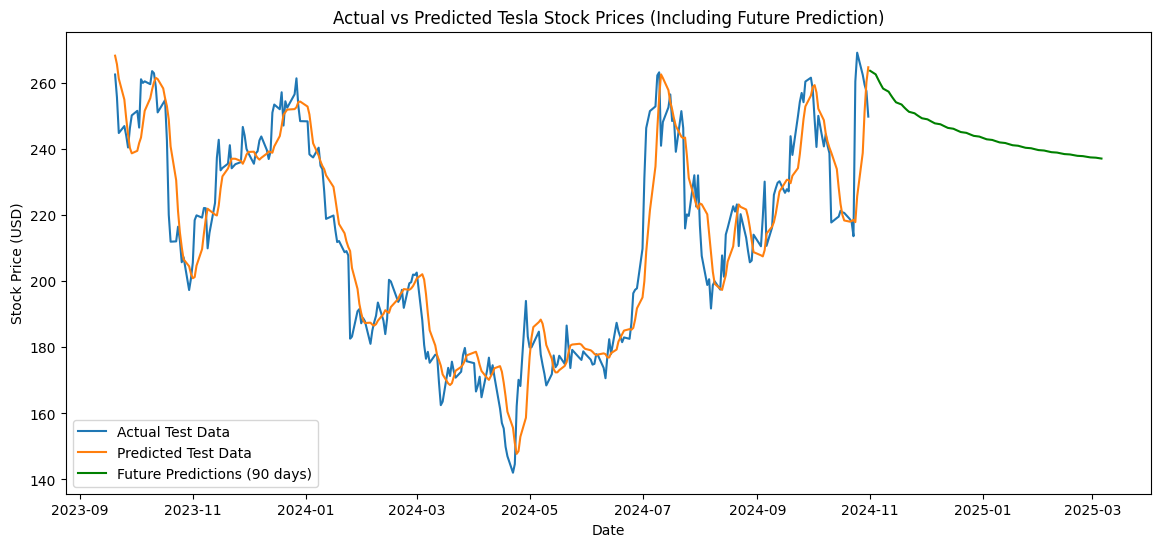

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Step 1: Load the data
tesla_data = pd.read_csv('Get_data/Tesla_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
sp500_data = pd.read_csv('Get_data/S&P500_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
ixic_data = pd.read_csv('Get_data/IXIC_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')

# Merge datasets on 'Date'
merged_data = tesla_data.merge(sp500_data, left_index=True, right_index=True, suffixes=('', '_sp500'))
merged_data = merged_data.merge(ixic_data, left_index=True, right_index=True, suffixes=('', '_ixic'))

# Step 2: Preprocess the data
data = merged_data[['Close', 'Close_sp500', 'Close_ixic']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare the dataset for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i])
        y.append(dataset[i, 0])  # Predict the 'Close' price of Tesla
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Build and train the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Step 4: Make predictions on the test set
test_predictions = model.predict(X_test)

# Rescale predictions and true values to original scale
test_predictions_rescaled = scaler.inverse_transform(
    np.hstack([test_predictions, X_test[:, -1, 1:]])
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), X_test[:, -1, 1:]])
)[:, 0]

# Step 5: Calculate performance metrics
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_predictions_rescaled))
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)

print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAPE: {test_mape:.2%}')
print(f'Test MAE: {test_mae:.2f}')

# Step 6: Predict future data (next 90 days)
last_60_days = scaled_data[-time_step:]
input_seq = last_60_days.reshape(1, last_60_days.shape[0], last_60_days.shape[1])

future_predictions = []
for _ in range(90):
    pred = model.predict(input_seq)
    future_predictions.append(pred[0, 0])
    next_step = np.zeros_like(input_seq)
    next_step[:, :-1, :] = input_seq[:, 1:, :]
    next_step[:, -1, 0] = pred  # Dự đoán giá trị mới cho cột 'Close'
    next_step[:, -1, 1:] = input_seq[:, -1, 1:]  # Giữ nguyên các biến ngoại vi
    input_seq = next_step

# Rescale future predictions
future_predictions_rescaled = scaler.inverse_transform(
    np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((90, 2))])
)[:, 0]

# Step 7: Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index[train_size + time_step:], y_test_rescaled, label='Actual Test Data')
plt.plot(merged_data.index[train_size + time_step:], test_predictions_rescaled, label='Predicted Test Data')
plt.plot(pd.date_range(start=merged_data.index[-1], periods=91, freq='B')[1:], future_predictions_rescaled, label='Future Predictions (90 days)', color='green')
plt.title('Actual vs Predicted Tesla Stock Prices (Including Future Prediction)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


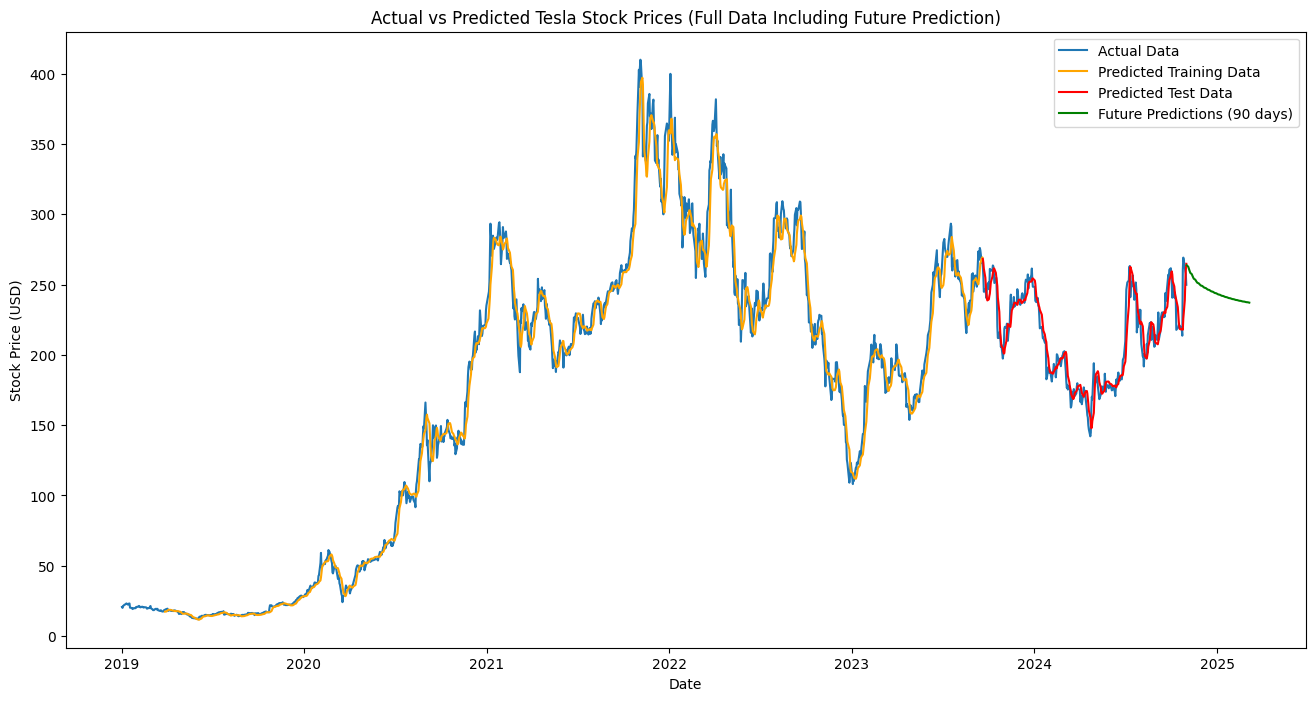

In [4]:
# Step 7: Plot predictions (full data visualization)
plt.figure(figsize=(16, 8))

# Plot actual data (từ năm 2019 đến hết năm 2024)
plt.plot(merged_data.index, merged_data['Close'], label='Actual Data')

# Plot training predictions (áp dụng mô hình trên tập huấn luyện)
train_predictions = model.predict(X_train)
train_predictions_rescaled = scaler.inverse_transform(
    np.hstack([train_predictions, X_train[:, -1, 1:]])
)[:, 0]

plt.plot(merged_data.index[time_step:train_size + time_step], train_predictions_rescaled, label='Predicted Training Data', color='orange')

# Plot test predictions
plt.plot(merged_data.index[train_size + time_step:], test_predictions_rescaled, label='Predicted Test Data', color='red')

# Plot future predictions
future_dates = pd.date_range(start=merged_data.index[-1], periods=91, freq='B')[1:]
plt.plot(future_dates, future_predictions_rescaled, label='Future Predictions (90 days)', color='green')

plt.title('Actual vs Predicted Tesla Stock Prices (Full Data Including Future Prediction)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


In [5]:
import numpy as np
import pandas as pd
import optuna
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load the data
tesla_data = pd.read_csv('Get_data/Tesla_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
sp500_data = pd.read_csv('Get_data/S&P500_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
ixic_data = pd.read_csv('Get_data/IXIC_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')

# Merge datasets on 'Date'
merged_data = tesla_data.merge(sp500_data, left_index=True, right_index=True, suffixes=('', '_sp500'))
merged_data = merged_data.merge(ixic_data, left_index=True, right_index=True, suffixes=('', '_ixic'))

# Step 2: Preprocess the data
data = merged_data[['Close', 'Close_sp500', 'Close_ixic']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare the dataset for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i])
        y.append(dataset[i, 0])  # Predict the 'Close' price of Tesla
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Function to create and train the LSTM model with Optuna
def objective(trial):
    # Hyperparameters to optimize
    lstm_units = trial.suggest_int('lstm_units', 10, 100)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 10, 100)

    # Build the LSTM model
model = Sequential([
    Input(shape=(time_step, X_train.shape[2])),
    LSTM(lstm_units, return_sequences=True),
    Dropout(dropout_rate),
    LSTM(lstm_units),
    Dropout(dropout_rate),
    Dense(1)
])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model
    test_predictions = model.predict(X_test)
    test_predictions_rescaled = scaler.inverse_transform(
        np.hstack([test_predictions, X_test[:, -1, 1:]])
    )[:, 0]
    y_test_rescaled = scaler.inverse_transform(
        np.hstack([y_test.reshape(-1, 1), X_test[:, -1, 1:]])
    )[:, 0]

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_predictions_rescaled))
    return rmse

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value (RMSE): {trial.value}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


IndentationError: unexpected indent (1010075242.py, line 48)